# Trading Strategies powered by Machine Learning - Support Vector Regression

## Support Vector Classifier with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv
pd.options.mode.chained_assignment = None  # default=

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


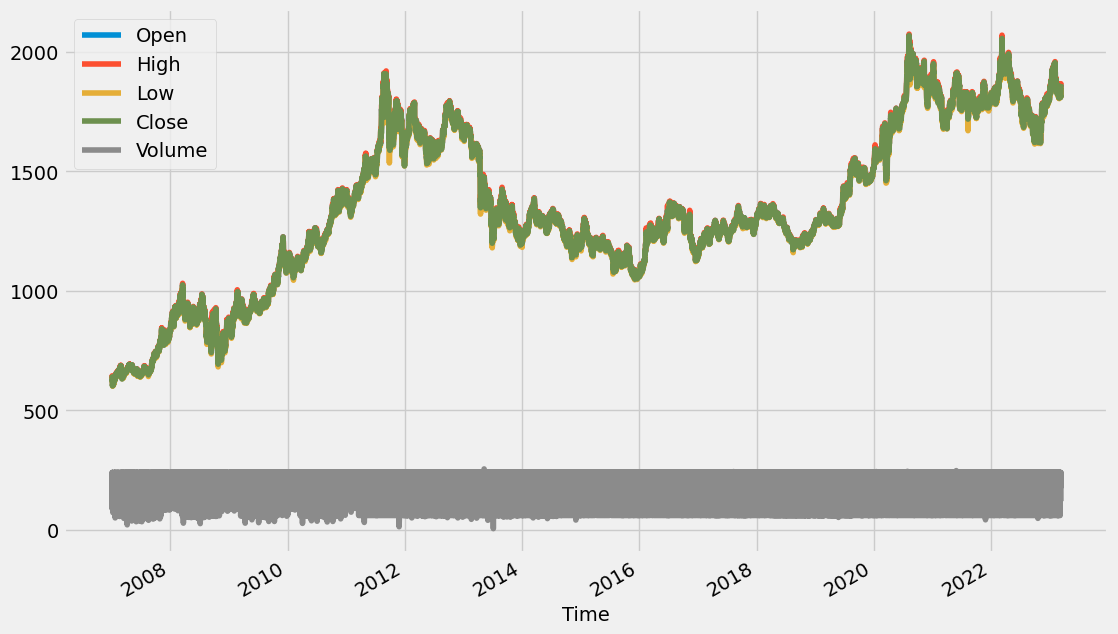

In [8]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [7]:
class Support_Vector_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [8]:
strategy = Support_Vector_Regression
account_size = 10000
folder_ML_Strategy = 'Support Vector Regression'

In [9]:
from sklearn.svm import SVR
from backtesting import Backtest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8")


class ML_SVR():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, future_days=1):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.future_days = future_days

    def Train_Model(self):
        df = self.data.copy()

        df[str(self.future_days) +
           '_Day_Price_Forecast'] = df['Close'].shift(-self.future_days)

        # Drop rows with NaN in the newly created column
        df.dropna(subset=[str(self.future_days) +
                  '_Day_Price_Forecast'], inplace=True)

        # Features (Close price as input)
        X = df[['Close']].copy()  # Corrected X to be a DataFrame
        Y = df[str(self.future_days) + '_Day_Price_Forecast'].copy()  # Target

        # Split data into train and test
        self.data_train = df.loc[self.start_train:self.end_train].copy()
        self.data_test = df.loc[self.start_test:self.end_test].copy()

        x_train = self.data_train[['Close']]
        y_train = Y.loc[self.start_train:self.end_train]
        x_test = self.data_test[['Close']]

        # Initialize and train the SVR model
        self.model = SVR(kernel='rbf', C=1e3, gamma=0.00001)
        self.model.fit(x_train, y_train)  # Removed unnecessary indexing

        # Make predictions
        self.data_train['Close_pred'] = self.model.predict(x_train)
        self.data_test['Close_pred'] = self.model.predict(x_test)

    def Add_Signal(self):

        self.data_train['pred'] = np.where(
            (self.data_train['Close_pred'] > self.data_train['Close']), 1, -1)
        self.data_test['pred'] = np.where(
            (self.data_test['Close_pred'] > self.data_test['Close']), 1, -1)

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100, commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):
        self.Train_Model()
        self.Add_Signal()

        result_train = self.Backtest(self.data_train)
        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_SVR

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [14]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [15]:
train, test = ml.Run()

### In-Sample Backtesting

In [16]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 11655.434763
Equity Peak [$]                  11837.779763
Return [%]                          16.554348
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    0.957249
Volatility (Ann.) [%]                1.738987
Sharpe Ratio                         0.550463
Sortino Ratio                        0.797015
Calmar Ratio                         0.175859
Max. Drawdown [%]                   -5.443284
Avg. Drawdown [%]                   -0.286304
Max. Drawdown Duration     2570 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                   53
Win Rate [%]                         84.90566
Best Trade [%]                     147.907079
Worst Trade [%]                    -10.733025
Avg. Trade [%]                    

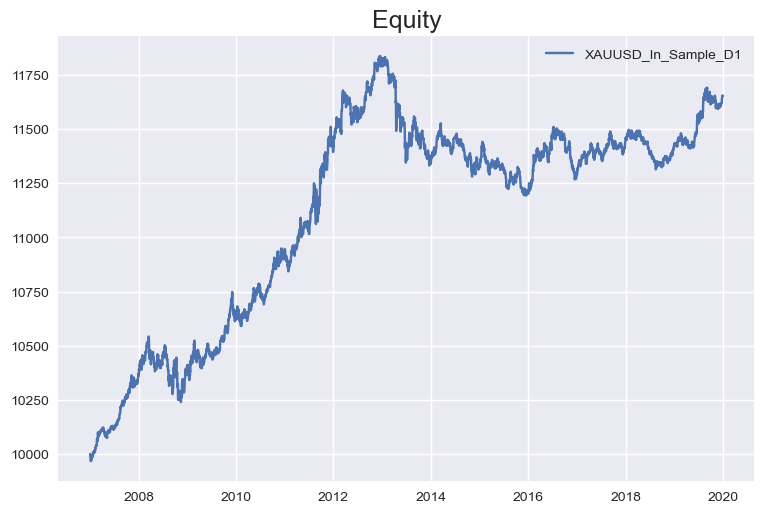

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                 10663.451204
Equity Peak [$]                  10772.298204
Return [%]                           6.634512
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                    1.648566
Volatility (Ann.) [%]                2.597424
Sharpe Ratio                         0.634692
Sortino Ratio                        1.018074
Calmar Ratio                         0.484932
Max. Drawdown [%]                   -3.399579
Avg. Drawdown [%]                   -0.738739
Max. Drawdown Duration      476 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                   30
Win Rate [%]                        96.666667
Best Trade [%]                      12.294971
Worst Trade [%]                     -6.089358
Avg. Trade [%]                    

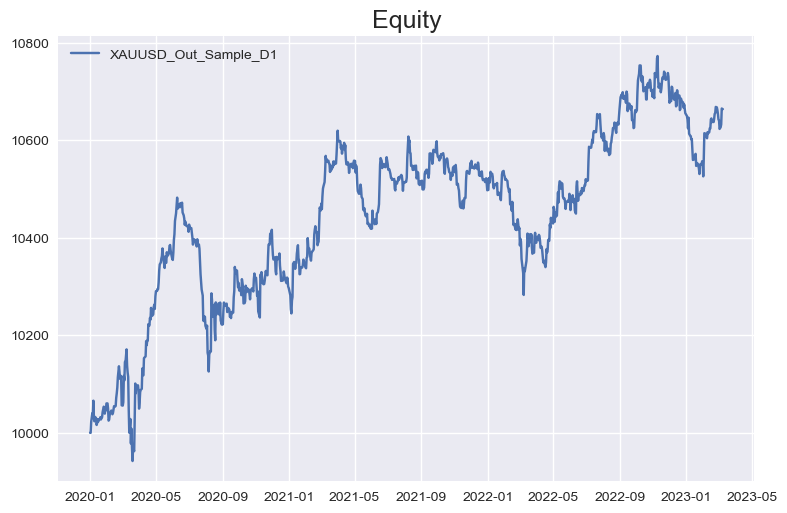

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [11]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

### In-Sample Backtesting

In [14]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                 10732.889764
Equity Peak [$]                  11228.757799
Return [%]                           7.328898
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                    0.440813
Volatility (Ann.) [%]                1.803217
Sharpe Ratio                         0.244459
Sortino Ratio                        0.345405
Calmar Ratio                         0.060174
Max. Drawdown [%]                   -7.325629
Avg. Drawdown [%]                   -0.227871
Max. Drawdown Duration     2993 days 12:00:00
Avg. Drawdown Duration       29 days 20:00:00
# Trades                                  363
Win Rate [%]                        52.341598
Best Trade [%]                       81.68072
Worst Trade [%]                    -20.848537
Avg. Trade [%]                    

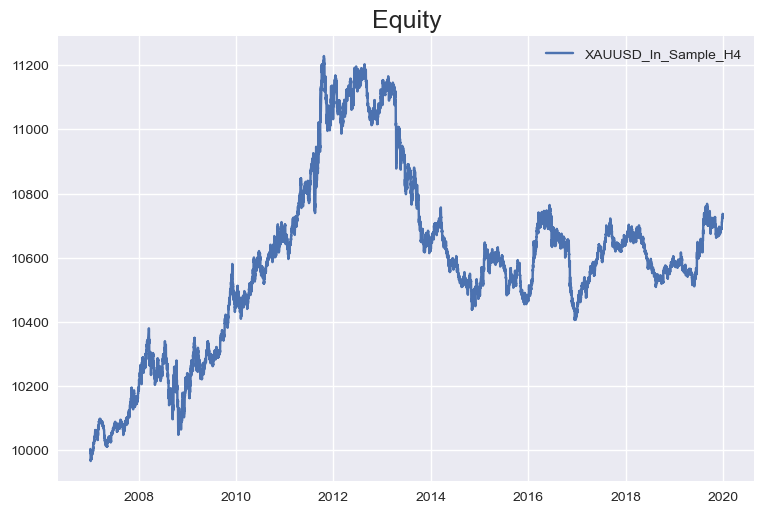

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                 10383.545886
Equity Peak [$]                  10482.404043
Return [%]                           3.835459
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                    0.961669
Volatility (Ann.) [%]                2.599622
Sharpe Ratio                         0.369926
Sortino Ratio                        0.562212
Calmar Ratio                         0.269919
Max. Drawdown [%]                   -3.562811
Avg. Drawdown [%]                   -0.378371
Max. Drawdown Duration      364 days 04:00:00
Avg. Drawdown Duration       23 days 14:00:00
# Trades                                  167
Win Rate [%]                        64.071856
Best Trade [%]                       8.067055
Worst Trade [%]                     -7.457182
Avg. Trade [%]                    

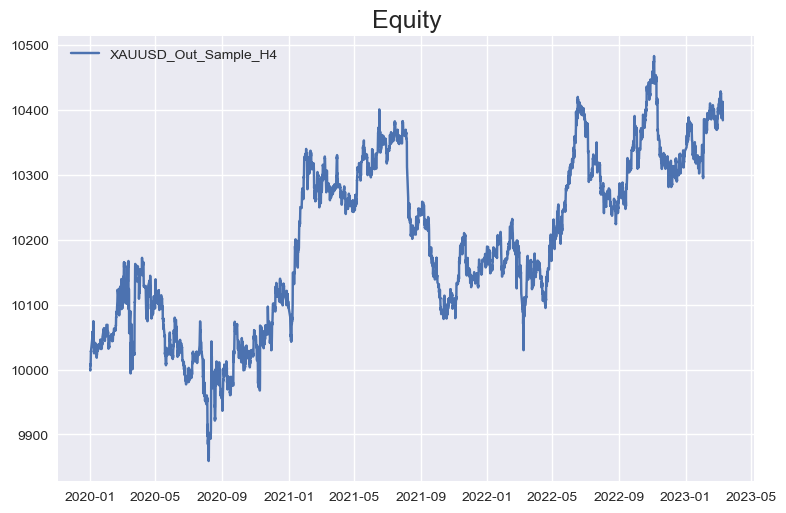

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [20]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [21]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [22]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [23]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [24]:
train, test = ml.Run()

### In-Sample Backtesting

In [25]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                 10944.117302
Equity Peak [$]                  10981.924302
Return [%]                           9.441173
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                    0.562374
Volatility (Ann.) [%]                1.796125
Sharpe Ratio                         0.313104
Sortino Ratio                        0.446245
Calmar Ratio                         0.154305
Max. Drawdown [%]                   -3.644567
Avg. Drawdown [%]                    -0.16252
Max. Drawdown Duration     1166 days 18:00:00
Avg. Drawdown Duration       17 days 08:00:00
# Trades                                  749
Win Rate [%]                         55.40721
Best Trade [%]                      85.345187
Worst Trade [%]                    -19.377762
Avg. Trade [%]                    

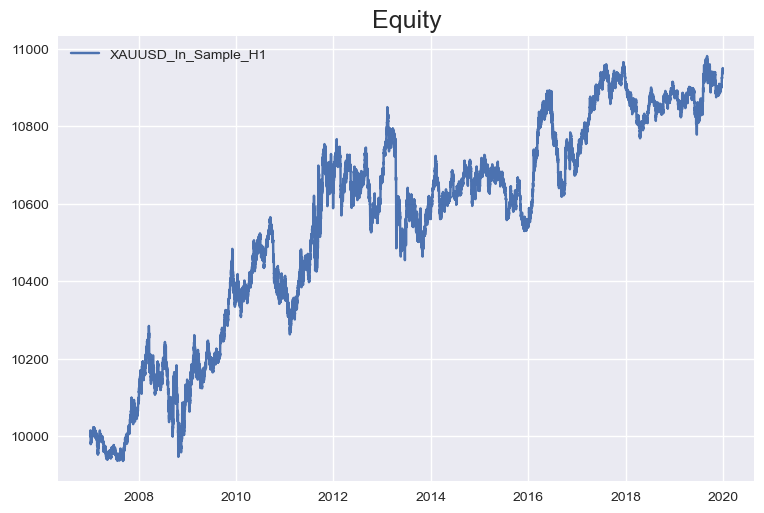

In [26]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [27]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                 10293.928203
Equity Peak [$]                  10510.750389
Return [%]                           2.939282
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                    0.739372
Volatility (Ann.) [%]                2.727026
Sharpe Ratio                         0.271128
Sortino Ratio                        0.408269
Calmar Ratio                         0.120387
Max. Drawdown [%]                   -6.141626
Avg. Drawdown [%]                   -0.255341
Max. Drawdown Duration      770 days 03:00:00
Avg. Drawdown Duration       14 days 08:00:00
# Trades                                  413
Win Rate [%]                        46.489104
Best Trade [%]                      10.110303
Worst Trade [%]                     -6.596609
Avg. Trade [%]                    

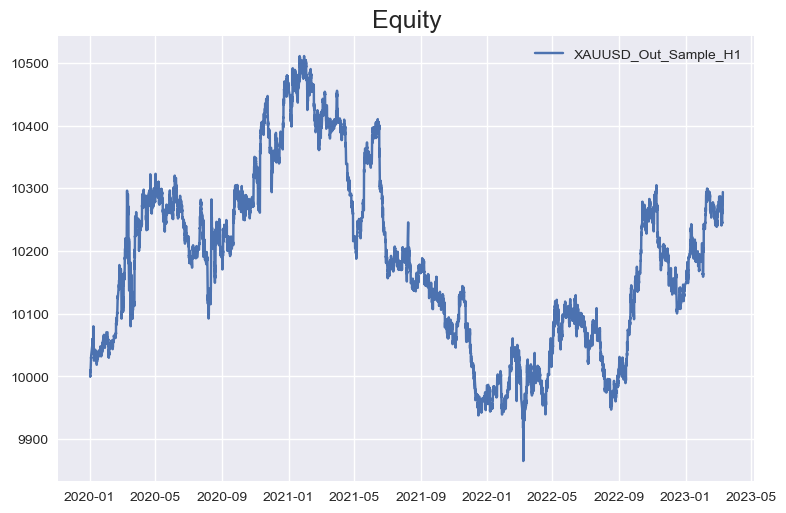

In [28]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [29]:
filename_train = f'result_{TF}_In_Sample.csv'

In [30]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [31]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [32]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [33]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [34]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [35]:
train, test = ml.Run()

### In-Sample Backtesting

In [36]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                 10184.447373
Equity Peak [$]                  10601.527524
Return [%]                           1.844474
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                     0.11371
Volatility (Ann.) [%]                1.877112
Sharpe Ratio                         0.060577
Sortino Ratio                        0.083772
Calmar Ratio                          0.01198
Max. Drawdown [%]                   -9.491762
Avg. Drawdown [%]                     -0.1397
Max. Drawdown Duration     3415 days 13:30:00
Avg. Drawdown Duration       22 days 21:47:00
# Trades                                 1443
Win Rate [%]                        48.717949
Best Trade [%]                      83.707738
Worst Trade [%]                    -11.726889
Avg. Trade [%]                    

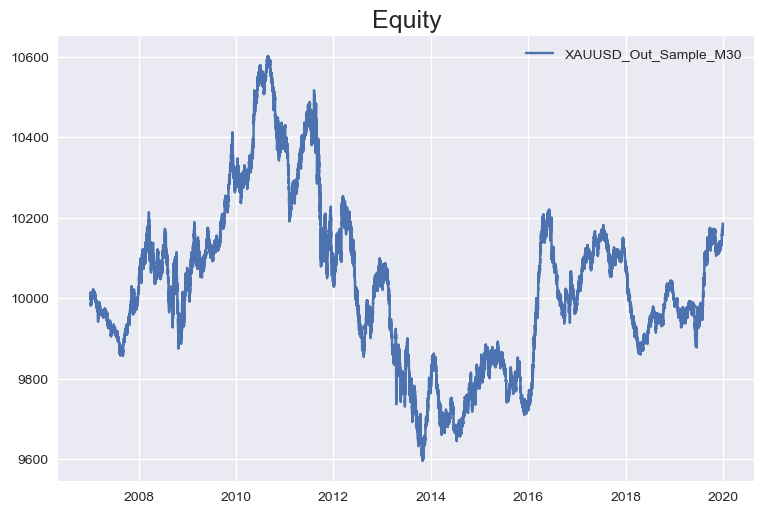

In [37]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [38]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                  9861.849489
Equity Peak [$]                  10511.378593
Return [%]                          -1.381505
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                   -0.353125
Volatility (Ann.) [%]                2.591592
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.126138
Avg. Drawdown [%]                   -0.216929
Max. Drawdown Duration      778 days 11:30:00
Avg. Drawdown Duration        9 days 05:08:00
# Trades                                  677
Win Rate [%]                        48.005908
Best Trade [%]                       7.149432
Worst Trade [%]                     -5.470547
Avg. Trade [%]                    

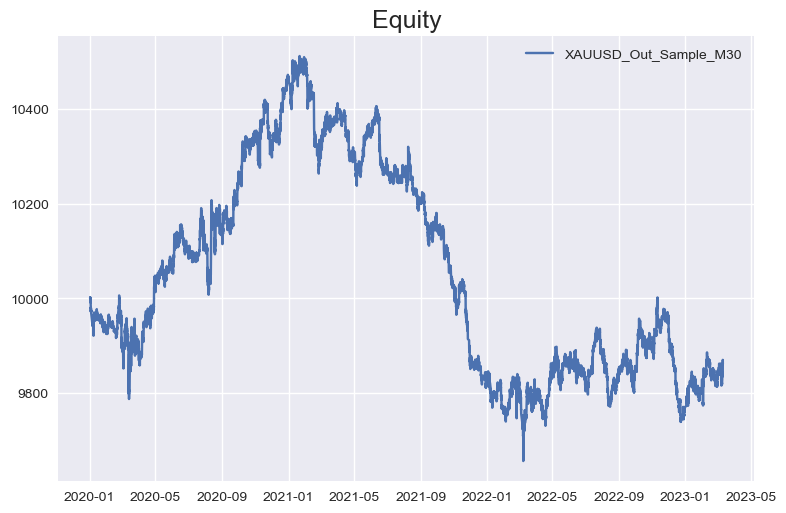

In [39]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [40]:
filename_train = f'result_{TF}_In_Sample.csv'

In [41]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')